In [ ]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as npi
import pandas as p
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

df=pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt',delimiter=';')

df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Convert features for better analysis
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_active_power']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)


In [ ]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000


In [ ]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-12-11 23:59:00


In [ ]:
df

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0
...,...,...,...,...,...,...,...
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0


In [ ]:
d=df["Global_active_power"]
d

0         4.2160
1         5.3600
2         5.3740
3         5.3880
4         3.6660
           ...  
2049275   0.6900
2049276   0.6880
2049277   0.6880
2049278   0.6880
2049279   0.6880
Name: Global_active_power, Length: 2049280, dtype: float64

In [ ]:
time=df["date_time"]
time

0         2006-12-16 17:24:00
1         2006-12-16 17:25:00
2         2006-12-16 17:26:00
3         2006-12-16 17:27:00
4         2006-12-16 17:28:00
                  ...        
2049275   2010-12-11 23:55:00
2049276   2010-12-11 23:56:00
2049277   2010-12-11 23:57:00
2049278   2010-12-11 23:58:00
2049279   2010-12-11 23:59:00
Name: date_time, Length: 2049280, dtype: datetime64[ns]

In [ ]:
df.index = pd.to_datetime(df.index)
selected = '2010-12-11'
res = df[(pd.to_datetime(selected)-pd.Timedelta(days=10)) : selected]
res

,date_time,Global_active_power,year,quarter,month,day,weekday


In [ ]:
mask = (df['InsertedDates'] > start_date) & (df['InsertedDates'] <= end_date)
df2 = df.loc[mask]

KeyError: ignored

In [ ]:

dataset=df.Global_active_power.values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [ ]:
dataset

In [ ]:

def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [ ]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

In [ ]:
model=tf.keras.Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
23420/23420 [==============================] - 139s 6ms/step - loss: 8.0531e-04 - val_loss: 4.5001e-04
Epoch 2/20
23420/23420 [==============================] - 124s 5ms/step - loss: 6.7102e-04 - val_loss: 4.2881e-04
Epoch 3/20
23420/23420 [==============================] - 134s 6ms/step - loss: 6.5507e-04 - val_loss: 4.7122e-04
Epoch 4/20
23420/23420 [==============================] - 135s 6ms/step - loss: 6.4361e-04 - val_loss: 4.5275e-04
Epoch 5/20
23420/23420 [==============================] - 135s 6ms/step - loss: 6.4046e-04 - val_loss: 4.3217e-04
Epoch 6/20
23420/23420 [==============================] - 120s 5ms/step - loss: 6.3774e-04 - val_loss: 4.3470e-04
Epoch 7/20
23420/23420 [==============================] - 134s 6ms/step - loss: 6.3687e-04 - val_loss: 4.2347e-04
Epoch 8/20
23420/23420 [==============================] - 130s 6ms/step - loss: 6.3536e-04 - val_loss: 4.2485e-04
Epoch 9/20
 2032/23420 [=>............................] - ETA: 1:32 - loss: 0.0010

In [ ]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))


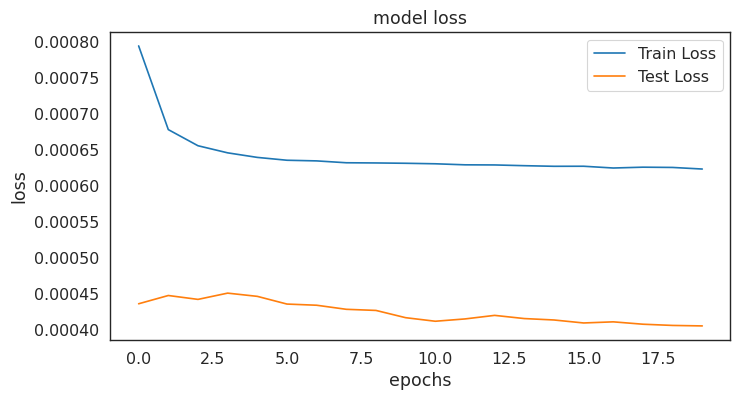

In [ ]:
#plot model losses
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

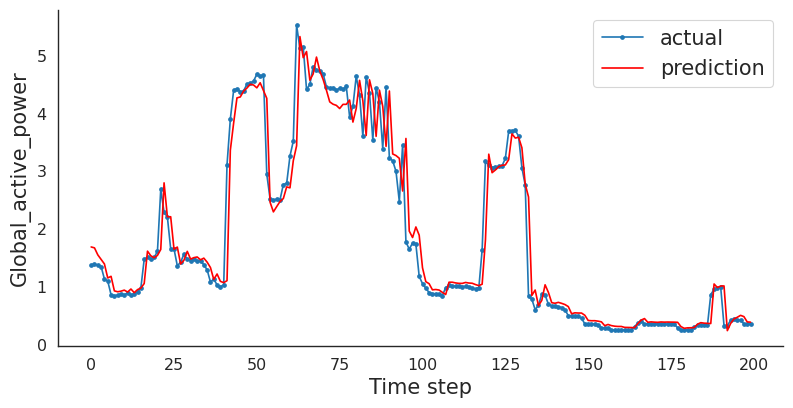

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();


In [ ]:
# Convert features for better analysis
df['date_time']=pd.to_datetime(df['Date']+' '+df['Time'])
df['Global_intensity']=pd.to_numeric(df['Global_intensity'],errors='coerce')
df=df.dropna(subset=['Global_intensity'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Global_intensity']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)

In [ ]:
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Global_intensity','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Number of rows and columns after removing missing values:',df.shape)
print('The time series starts from:',df['date_time'].min())
print('The time series ends on:',df['date_time'].max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from: 2006-12-16 17:24:00
The time series ends on: 2010-12-11 23:59:00


In [ ]:
dataset=df.Global_intensity.values
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
train,test =dataset[0:train_size,:],dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(train,look_back)
x_test,y_test=create_dataset(test,look_back)

# Reshape inputs
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [ ]:
model=tf.keras.Sequential()
model.add(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x_train,y_train, epochs=20, batch_size=70,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
23420/23420 [==============================] - 86s 4ms/step - loss: 7.6105e-04 - val_loss: 4.0658e-04
Epoch 2/20
23420/23420 [==============================] - 81s 3ms/step - loss: 6.4103e-04 - val_loss: 4.3556e-04
Epoch 3/20
23420/23420 [==============================] - 86s 4ms/step - loss: 6.1831e-04 - val_loss: 4.2737e-04
Epoch 4/20
23420/23420 [==============================] - 83s 4ms/step - loss: 6.1549e-04 - val_loss: 4.0963e-04
Epoch 5/20
23420/23420 [==============================] - 87s 4ms/step - loss: 6.0727e-04 - val_loss: 4.1555e-04
Epoch 6/20
23420/23420 [==============================] - 82s 4ms/step - loss: 6.0427e-04 - val_loss: 4.0486e-04
Epoch 7/20
23420/23420 [==============================] - 83s 4ms/step - loss: 6.0283e-04 - val_loss: 4.2218e-04
Epoch 8/20
23420/23420 [==============================] - 83s 4ms/step - loss: 6.0110e-04 - val_loss: 4.0531e-04
Epoch 9/20
23420/23420 [==============================] - 86s 4ms/step - loss: 6.0214e-04 - val_

In [ ]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))


 6234/51232 [==>...........................] - ETA: 57s

In [ ]:
#plot model losses
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_intensity', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
